<a href="https://colab.research.google.com/github/SalehMehrabani/PyTorch-Deep-Learning/blob/main/CNN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolution Neural Network
* PyTorch Convolutional Neural Network
* Food 101 dataset


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import ToTensor


In [2]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##Get Data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

    # Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...") 
  zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## Data Preparation and Data Exploration

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} image is {dirpath}")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 image is data/pizza_steak_sushi
There are 3 directories and 0 image is data/pizza_steak_sushi/train
There are 0 directories and 78 image is data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 image is data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 image is data/pizza_steak_sushi/train/steak
There are 3 directories and 0 image is data/pizza_steak_sushi/test
There are 0 directories and 25 image is data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 image is data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 image is data/pizza_steak_sushi/test/steak


In [6]:
#Setup training and testing paths
train_dir = image_path / "train"
test_dir= image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

##Visualizing image
* Get all of the image paths
* pick a random image path using Python's `random.choice()`
* Get the image class name using `pathlib.Path.parent.stem`
* Open image with Python **PIL** Library
* Show the image and print metadata 

Image path: data/pizza_steak_sushi/train/pizza/2760984.jpg
Image class: pizza
Image heigh: 512 
Image width: 512


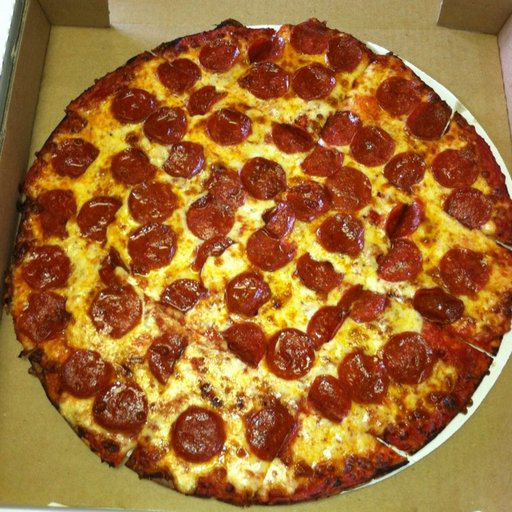

In [7]:
import random
from PIL import Image

# random.seed(42)

#Get all image path
image_path_list=list(image_path.glob("*/*/*.jpg"))
#Pick a random image path
random_image_path= random.choice(image_path_list)
#Get the image class form the path name(the image class is the name of the directory)
image_class= random_image_path.parent.stem
#Open image
img= Image.open(random_image_path)
#Print metadata
print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image heigh: {img.height} ")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

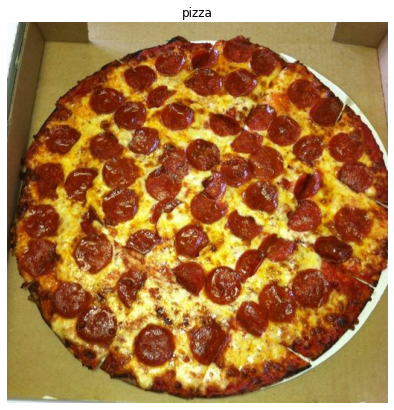

In [8]:
import numpy as np
import matplotlib.pyplot as plt

#Turn the image into the array
img_as_array= np.asarray(img)
#Plot the image 
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(image_class)
plt.axis(False)

##Transforming data into tensor

In [9]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [10]:
data_transforms= transforms.Compose([
    #Resize the image into 64x64
    transforms.Resize(size=(64,64)),
    #Flip the images randomly
    transforms.RandomHorizontalFlip(p=0.5),
    #Trun the imgae to tensor
    transforms.ToTensor()
])

In [11]:
data_transforms(img).shape

torch.Size([3, 64, 64])

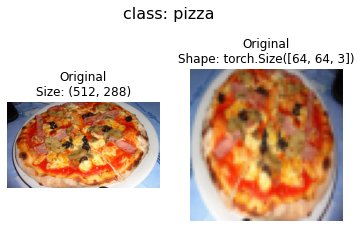

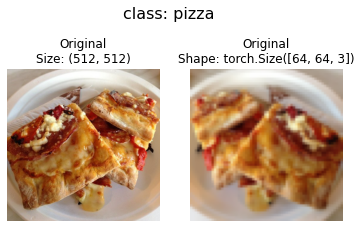

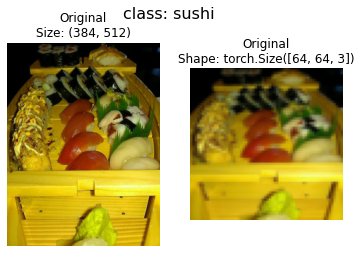

In [12]:
def plot_transformed_images(image_paths: list,
                            transform,
                            n=3,
                            seed=None):
  if seed:
    random.seed(seed)
  random_image_paths= random.sample(image_paths, k=n) 
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2) 
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #Transfom and plot target image
      transformed_image = transform(f).permute(1,2,0) #(C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Original\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths= image_path_list,
                        transform = data_transforms,
                        n=3, seed=42)  

##Option 1: Loading image data using `torchvision.datasets.ImageFolder`

In [13]:
from torchvision import datasets

train_data = datasets.ImageFolder(
    root= train_dir, 
    transform= data_transforms,
    target_transform= None
)
test_data= datasets.ImageFolder(
    root= test_dir,
    transform= data_transforms,
    target_transform= None
)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
#Get class names as list
class_names= train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
class_dict= train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
len(train_data), len(test_data)

(225, 75)

In [17]:
img, label = train_data[2][0], train_data[2][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.2314, 0.2314, 0.2275,  ..., 0.0431, 0.0392, 0.0392],
         [0.2196, 0.2235, 0.2196,  ..., 0.0392, 0.0392, 0.0392],
         [0.2118, 0.2118, 0.2078,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4039, 0.4863, 0.5373,  ..., 0.7961, 0.8078, 0.8118],
         [0.1608, 0.1961, 0.2902,  ..., 0.6392, 0.6157, 0.5176],
         [0.0784, 0.0902, 0.1216,  ..., 0.3647, 0.3333, 0.2863]],

        [[0.1922, 0.1922, 0.1922,  ..., 0.0392, 0.0353, 0.0353],
         [0.1843, 0.1843, 0.1804,  ..., 0.0353, 0.0353, 0.0353],
         [0.1765, 0.1725, 0.1765,  ..., 0.0392, 0.0353, 0.0353],
         ...,
         [0.3176, 0.4000, 0.4588,  ..., 0.5333, 0.5373, 0.5804],
         [0.1098, 0.1373, 0.2196,  ..., 0.3882, 0.3765, 0.2941],
         [0.0588, 0.0706, 0.0863,  ..., 0.1686, 0.1608, 0.1529]],

        [[0.2078, 0.2000, 0.1961,  ..., 0.0196, 0.0157, 0.0157],
         [0.1882, 0.1843, 0.1843,  ..., 0.0157, 0.0157, 0.0157],
         [0.1725, 0.1686, 0.1686,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


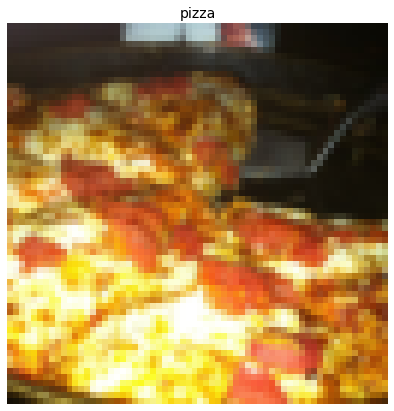

In [18]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [19]:
from torch.utils.data import DataLoader

BATCH_SIZE= 1

train_dataloader= DataLoader(
    dataset= train_data,
    batch_size= BATCH_SIZE,
    num_workers= 1,
    shuffle= True
)
test_dataloader= DataLoader(
    dataset= test_data,
    batch_size= BATCH_SIZE,
    num_workers= 1,
    shuffle= False
)

In [20]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Option 2: Loading image data with custom `Dataset`
1. Want to be able to load images from file
2. Want to able to get class name from the dataset
3. Want to able to get class name as dictionary from dataset



In [21]:
import os
import pathlib
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

Creating a helper function to get the class name
1. get the class names using `os.scandir()` to traverse a target directory (ideally the directory in standard image classification format)
2. Raise an error if the class name are'nt found
3. Turn the class name to list and dict and return them


In [22]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [23]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx 

In [24]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

###Create Custom Dataset
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory and transform function
3. Create several attributes: 
  * paths- paths of our image
  * transform - the Custom trasform function 
  * classes - a list of target classes
  * class_t0_idx - a dict of the target classes mapped to integer label
4. Create a function to `load_images()`, this function will opent an image
5. Overwrite the `__len__()` methods to return the lenght of our dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index.

In [25]:
#write a custome dataset
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self, 
               targ_dir: str,
               transform = None,):
    self.paths= list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform= transform
    self.classes, self.class_to_idx= find_classes(targ_dir)
  
  def load_image(self, index: int) -> Image.Image:
    image_path= self.paths[index]
    return Image.open(image_path)
  
  def __len__(self) -> int:
    return len(self.paths)
  
  def __getitem__(self, index: int) ->Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name= self.paths[index].parent.name
    class_idx= self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else: 
      return img, class_idx

In [26]:
#Create A transform
train_transform= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
]) 
test_transform= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [27]:
train_data_custom = ImageFolderCustom(
    targ_dir= train_dir,
    transform= train_transform 
)
test_data_custom= ImageFolderCustom(
    targ_dir= test_dir,
    transform= test_transform
)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fc0a1dc2190>,
 <__main__.ImageFolderCustom at 0x7fc0a1dc2b80>)

In [28]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [29]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [30]:
test_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [31]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [32]:
#Create a function to display a random images 
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  if n>10: 
    n=10
    display_shape= False
    print(f"For display, purposes, n should'nt be larger than 10, setting to 10 and removing sahpe display")
  
  if seed:
    random.seed(seed)
  
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label= dataset[targ_sample][0], dataset[targ_sample][1]
    targ_image_adjust= targ_image.permute(1,2,0) #[Color_channels, Height, Width]-> [Height, Width, color_Channels]

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)

    if classes:
      title= f"Class: {classes[targ_label]}"
      if display_shape:
        title= title + f"\shape: {targ_image_adjust.shape}"
    
    plt.title(title)


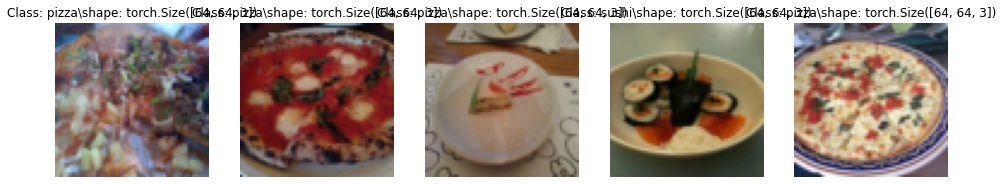

In [33]:
display_random_images(train_data, n= 5,
                     classes= class_names,
                     seed=None)

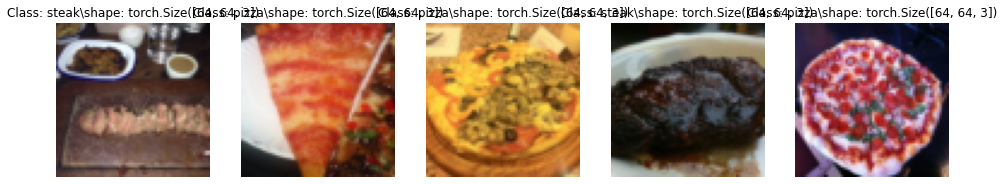

In [34]:
#Display Random images from our ImageFolderCustom Dataset
display_random_images(train_data_custom, n=5, classes=class_names, seed=42, display_shape=True)

In [35]:
BATCH_SIZE= 32
train_dataloader_custom= DataLoader(
    dataset= train_data_custom, 
    batch_size= BATCH_SIZE,
    num_workers= 0,
    shuffle= True, 
)
test_dataloader_custom= DataLoader(
    dataset= test_data_custom,
    batch_size= BATCH_SIZE,
    num_workers= 0,
    shuffle=False
)

In [36]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## Data Augmentation

In [37]:
from torchvision import transforms

train_transforms= transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms. TrivialAugmentWide(num_magnitude_bins= 31),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

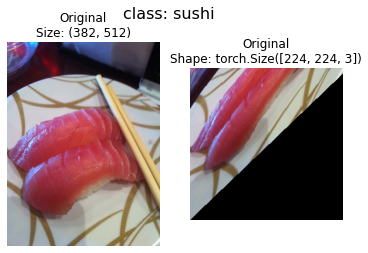

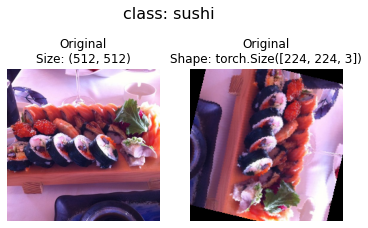

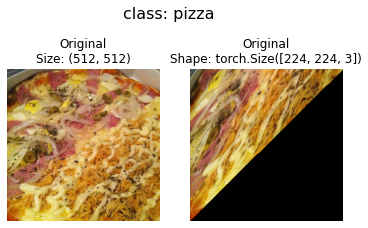

In [38]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)


##Model V0

In [39]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [40]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7fc0a13b4940>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc0a151f3a0>)

In [41]:
#Replicat the Tiny VGG From CNN Explainer Website
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block1= nn.Sequential(
        nn.Conv2d(in_channels=input_shape, 
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding=1),
        nn.ReLU(),
        #In MaxPool2d the default stride value is same as kernel size
        nn.MaxPool2d(kernel_size=2,
                     stride= 2)
      )
    self.conv_block2= nn.Sequential(
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2,
                     stride= 2)
      )
    self.classifier= nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units*16*16, output_shape)
      )
  def forward(self, x):
    x= self.conv_block1(x)
    x= self.conv_block2(x)
    x= self.classifier(x)
    return x
    

In [42]:
torch.manual_seed(42)
model_0= TinyVGG(input_shape= 3,
                 hidden_units= 10,
                 output_shape= 3)
model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

###torchinfo

In [43]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### Functionizing training and testing step

In [44]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [45]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [46]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [47]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1360 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0847 | train_acc: 0.4258 | test_loss: 1.1620 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1157 | train_acc: 0.2930 | test_loss: 1.1697 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0956 | train_acc: 0.4141 | test_loss: 1.1385 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0985 | train_acc: 0.2930 | test_loss: 1.1427 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.0956 | train_acc: 0.2500 | test_loss: 1.1463 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1188 | train_acc: 0.3047 | test_loss: 1.1419 | test_acc: 0.2708
Epoch: 8 | train_loss: 1.1039 | train_acc: 0.3438 | test_loss: 1.1099 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.0961 | train_acc: 0.4414 | test_loss: 1.0916 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.0913 | train_acc: 0.4023 | test_loss: 1.0796 | test_acc: 0.5417
Epoch: 11 | train_loss: 1.0855 | train_acc: 0.4023 | test_loss: 1.0645 | test_acc: 0.5417
Epoch: 12 | train_l

In [48]:
model_0_results

{'train_loss': [1.1078328788280487,
  1.0847126692533493,
  1.1156974732875824,
  1.0955534279346466,
  1.0985286235809326,
  1.0955947190523148,
  1.118793711066246,
  1.1038944572210312,
  1.0960527211427689,
  1.0912997722625732,
  1.0855244472622871,
  1.1338895857334137,
  1.076757699251175,
  1.0807576030492783,
  1.0253630578517914,
  0.9122536554932594,
  0.9421481043100357,
  0.9268345087766647,
  0.895734965801239,
  1.1009638831019402],
 'train_acc': [0.2578125,
  0.42578125,
  0.29296875,
  0.4140625,
  0.29296875,
  0.25,
  0.3046875,
  0.34375,
  0.44140625,
  0.40234375,
  0.40234375,
  0.28125,
  0.41796875,
  0.30859375,
  0.52734375,
  0.51953125,
  0.6484375,
  0.578125,
  0.53515625,
  0.5390625],
 'test_loss': [1.1360409657160442,
  1.1620127360026042,
  1.1697029272715251,
  1.1384957631429036,
  1.1426998774210613,
  1.1463404893875122,
  1.141874631245931,
  1.1099159320195515,
  1.0916223526000977,
  1.0795971552530925,
  1.0644646883010864,
  1.043114860852559

In [49]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

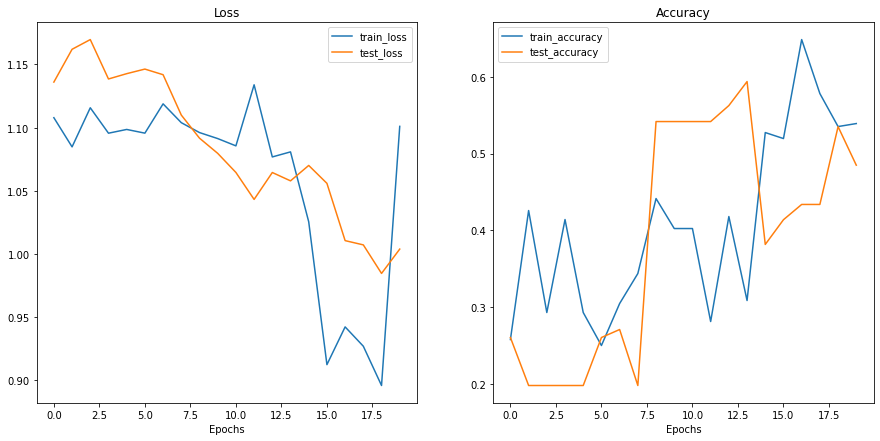

In [50]:
plot_loss_curves(model_0_results)

In [51]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [52]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [53]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fc0847d6400>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc0a1dd4640>)

In [54]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [55]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1061 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1387 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0812 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1292 | train_acc: 0.3047 | test_loss: 1.1628 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0901 | train_acc: 0.4258 | test_loss: 1.1486 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.0962 | train_acc: 0.3047 | test_loss: 1.1458 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.0897 | train_acc: 0.4531 | test_loss: 1.1416 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1088 | train_acc: 0.2930 | test_loss: 1.1465 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1199 | train_acc: 0.2930 | test_loss: 1.1506 | test_acc: 0.2812
Epoch: 10 | train_loss: 1.0803 | train_acc: 0.5234 | test_loss: 1.0973 | test_acc: 0.3324
Epoch: 11 | train_loss: 1.0659 | train_acc: 0.4492 | test_loss: 1.0666 | test_acc: 0.4735
Epoch: 12 | train_l

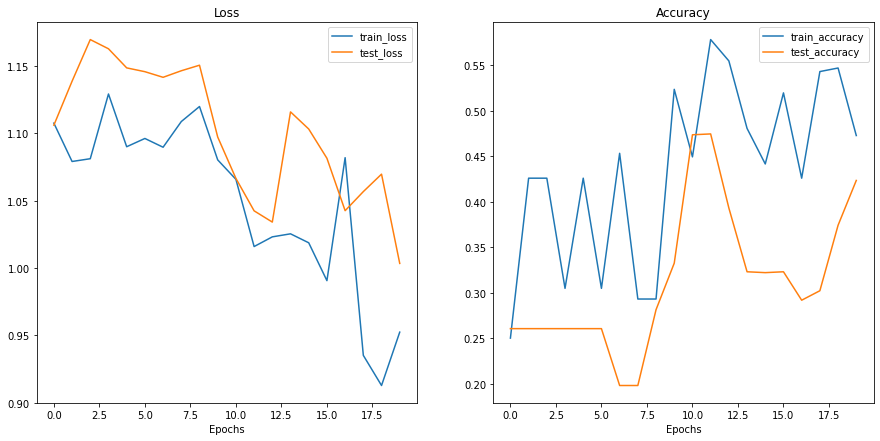

In [56]:
plot_loss_curves(model_1_results)

In [57]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107833,0.257812,1.136041,0.260417
1,1.084713,0.425781,1.162013,0.197917
2,1.115697,0.292969,1.169703,0.197917
3,1.095553,0.414062,1.138496,0.197917
4,1.098529,0.292969,1.142700,0.197917
5,1.095595,0.250000,1.146340,0.260417
6,1.118794,0.304688,1.141875,0.270833
7,1.103894,0.343750,1.109916,0.197917
8,1.096053,0.441406,1.091622,0.541667
9,1.091300,0.402344,1.079597,0.541667


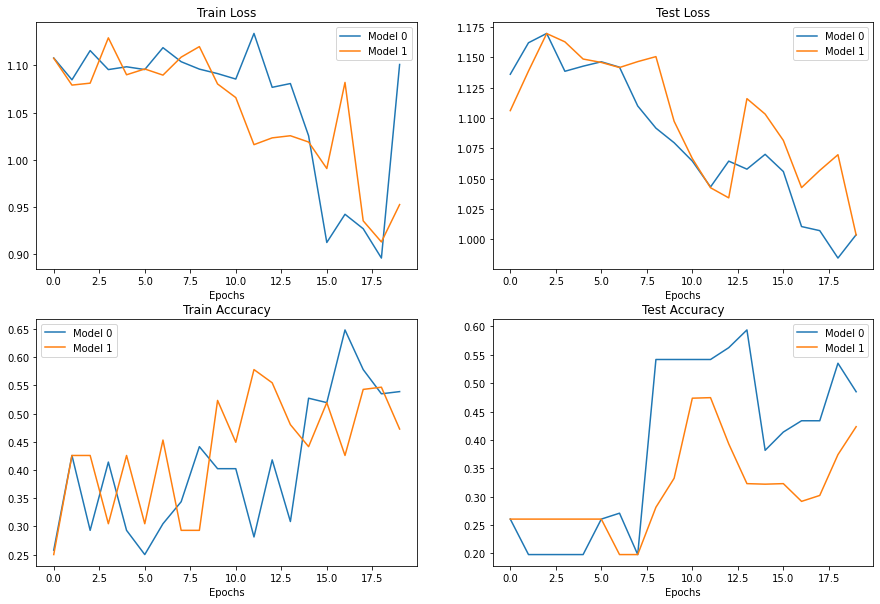

In [58]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [59]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [74]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

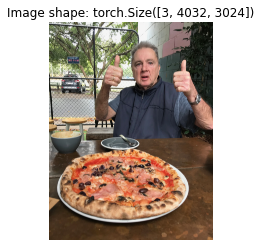

In [75]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [76]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [77]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [78]:
custom_image_pred

tensor([[-0.1502, -0.3463, -0.3039]], device='cuda:0')

In [79]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-0.1502, -0.3463, -0.3039]], device='cuda:0')
Prediction probabilities: tensor([[0.3732, 0.3068, 0.3200]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [80]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3732, 0.3068, 0.3200]], device='cuda:0')

In [81]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

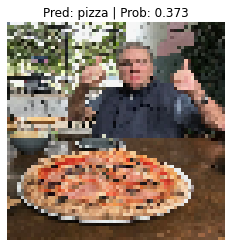

In [82]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)